In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read data
train = pd.read_csv('op_firstrun_raw.csv')

In [3]:
train.shape

(111379, 160)

In [4]:
train.head()

,deal_uuid,deal_key,sf_id,deal_year,deal_month,actual_start_date,actual_end_date,voucher_age,days_ran,division_key,...,market_ly_60_merchant_count,market_ly_60_avg_discount,market_ly_60_avg_price,sh_365_avg_deal_gb,sh_365_avg_udv_30,sh_365_avg_udv_90,sh_365_deal_count,sh_365_merchant_count,sh_365_avg_discount,sh_365_avg_price
0,b8f33fe6-4776-4326-984a-071823c0d7dd,43563263,001C000001YfzvGIAR,2017,1,2017-01-15,2017-01-18,NaN,4,3500034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b8fb9088-2dcf-42b1-aa05-ab09018a43e6,43609398,001C000001ZT9XnIAL,2017,2,2017-02-10,2017-02-13,NaN,4,3500116,...,NaN,NaN,NaN,123.0,64.0,95.0,1.0,1.0,96.000000,60.666668
2,b8fcbb48-4093-4af2-8b2d-ef0a71700b8b,43624780,001C000001ZalFqIAJ,2017,2,2017-02-16,2017-02-19,NaN,4,3500179,...,NaN,NaN,NaN,2888.0,1550.0,2495.0,1.0,1.0,22.333334,66.666664
3,b9043a56-193a-4cbf-bd6a-e608acdd36af,43632667,001C000001ZTkrZIAT,2017,2,2017-02-22,2017-02-21,NaN,0,3500021,...,NaN,NaN,NaN,292.0,623.0,624.0,1.0,1.0,34.875000,36.375000
4,b90c37fa-4375-4f52-b406-5722717152c9,43614626,001C000001ZZwFjIAL,2017,2,2017-02-08,2017-02-11,NaN,4,3500161,...,NaN,NaN,NaN,26195.0,1815.0,3240.0,1.0,1.0,183.500000,51.000000


In [5]:
#remove previous performance features 
#list comprehension
keep_ind = ['avg_pp' not in col for col in train.columns]
train = train.loc[:, keep_ind]

#other approachs 
#map function to the list 
#remove_ind = list(map(lambda x: 'avg_pp' not in x, train.columns.tolist()))

In [6]:
train.shape

(111379, 141)

In [7]:
#transfor gb to log_gb
# def log_transfer(x):
#     if x == 0:
#         return 0
#     else:
#         return np.log(x)
# train['log_gb'] = train.gross_bookings.apply(log_transfer)
# #np.log is ln and we have np.log10

#Other approach 
#np.where is equivalent to ifelse in R
train['log_gb'] = np.where(train.gross_bookings == 0, 0, np.log(train.gross_bookings))

/Users/rwang/Desktop/Projects/pfboy/op/env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
train.log_gb.describe()

count    111379.000000
mean          6.978241
std           2.040110
min           0.000000
25%           5.480639
50%           6.965628
75%           8.454040
max          15.887263
Name: log_gb, dtype: float64

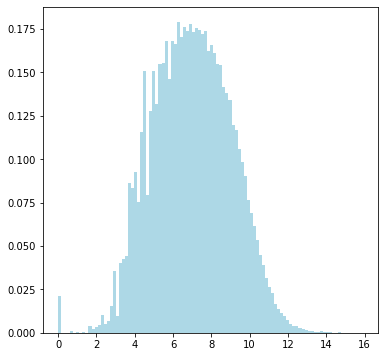

In [9]:
#plot log_gb
plt.figure(figsize = (6,6))
plt.hist(train['log_gb'], bins = 100, density = True, color = 'lightblue')
plt.show()
# plt.ylabel('Probability')

In [10]:
# train['service'].value_counts().reset_index()

In [11]:
#When we reset the index, the old index is added as a column, and a new sequential index is used:
# train.groupby('service')['deal_uuid'].nunique().reset_index(name = 'count').sort_values(by = 'count')

In [12]:
#Merge small pds to other
# pds_count = train.groupby('service')['deal_uuid'].count().sort_values(ascending=False)
pds_count = train.groupby('service')['deal_uuid'].count().reset_index(name = 'count').sort_values(by = 'count')

In [13]:
pds_count.head()

,service,count
1374,Safety & Security,1
787,Handball,1
278,Cigar Knowledge,1
277,Churros,1
276,Christmas Market,1


In [14]:
pds_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1771 entries, 1374 to 571
Data columns (total 2 columns):
service    1771 non-null object
count      1771 non-null int64
dtypes: int64(1), object(1)
memory usage: 41.5+ KB


In [15]:
small_pds = pds_count.loc[pds_count['count'] <= 20,'service'].tolist()
small_pds_index = [i in small_pds for i in train.service]
train.loc[small_pds_index, 'service'] = 'other'

In [16]:
train.dtypes

deal_uuid                 object
deal_key                   int64
sf_id                     object
deal_year                  int64
deal_month                 int64
                          ...   
sh_365_deal_count        float64
sh_365_merchant_count    float64
sh_365_avg_discount      float64
sh_365_avg_price         float64
log_gb                   float64
Length: 142, dtype: object

In [17]:
train.service.dtypes

dtype('O')

In [18]:
train.isnull().sum()

deal_uuid                    0
deal_key                     0
sf_id                        0
deal_year                    0
deal_month                   0
                         ...  
sh_365_deal_count        20400
sh_365_merchant_count    20400
sh_365_avg_discount      20402
sh_365_avg_price         20400
log_gb                       0
Length: 142, dtype: int64

In [19]:
#impute missing valutes 
sum(train.isnull().sum() != 0)

88

In [20]:
# train.columns[train.isnull().sum() != 0].tolist()

In [21]:
train.loc[:, train.isnull().sum() != 0].head()

,voucher_age,division_permalink,division,peer_group,refund_rate,pds_cat_id,pds_cat_name,service_header_id,service_header,min_retail_price,...,market_ly_60_merchant_count,market_ly_60_avg_discount,market_ly_60_avg_price,sh_365_avg_deal_gb,sh_365_avg_udv_30,sh_365_avg_udv_90,sh_365_deal_count,sh_365_merchant_count,sh_365_avg_discount,sh_365_avg_price
0,NaN,houston,Houston,Group 2,0.000000,b45bfe48-f179-435b-a38b-c23a73e21bb2,Mobile Phone / Smartphone Repair,ce912fbf-c97e-46b5-8809-40b2cb58004e,Electronics Repair,95.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,charlotte,Charlotte,Group 3,0.200000,8562ec12-4eef-489b-aed8-d4e732d41e27,Yoga,6358b622-f11f-4394-8111-7c33bdf71800,Workout & Fitness,60.00,...,NaN,NaN,NaN,123.0,64.0,95.0,1.0,1.0,96.000000,60.666668
2,NaN,orange-county,Orange County,Group 2,0.099573,9b1f83bd-d267-48dc-8f08-63b0da320d4e,Exterior & Interior Detail,0820f312-fa36-4d33-9851-d567d2c2adb8,Car Wash / Detail,29.99,...,NaN,NaN,NaN,2888.0,1550.0,2495.0,1.0,1.0,22.333334,66.666664
3,NaN,albany-capital-region,Albany / Capital Region,Group 5,0.241379,4387ccd5-c9c1-4181-aa8a-2418e75d5f81,Waxing - Brazilian,f1a78b47-9d95-4b6d-9593-bd563f9d7cee,Hair Removal & Epilation,54.00,...,NaN,NaN,NaN,292.0,623.0,624.0,1.0,1.0,34.875000,36.375000
4,NaN,madison,Madison,Group 4,0.076923,78d00183-d0eb-4865-b755-9c4c0264f546,Skin Care,6f0b410e-7a52-4ea0-b206-b7f85b49c33b,Health & Beauty,149.00,...,NaN,NaN,NaN,26195.0,1815.0,3240.0,1.0,1.0,183.500000,51.000000


In [22]:
missing_columns = train.columns[train.isnull().sum() != 0].tolist()

In [23]:
# Filling missing values with median and mode
for col in missing_columns:
    if train[col].dtype == 'O':
        #train.loc[train[col].isnull(),col] = train[col].mode()[0]
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        #train.loc[train[col].isnull(),col] = np.nanmedian(train[col])
        train[col] = train[col].fillna(np.nanmedian(train[col]))
        

In [24]:
train.isnull().sum()

deal_uuid                0
deal_key                 0
sf_id                    0
deal_year                0
deal_month               0
                        ..
sh_365_deal_count        0
sh_365_merchant_count    0
sh_365_avg_discount      0
sh_365_avg_price         0
log_gb                   0
Length: 142, dtype: int64

In [25]:
sum(train.apply(lambda x : x == None).sum() != 0)

0

In [26]:
train.apply(lambda x : x == None).sum()

deal_uuid                0
deal_key                 0
sf_id                    0
deal_year                0
deal_month               0
                        ..
sh_365_deal_count        0
sh_365_merchant_count    0
sh_365_avg_discount      0
sh_365_avg_price         0
log_gb                   0
Length: 142, dtype: int64

### Build first stage gbm model

In [27]:
category = ['division','service_header','service','competitor_name','log_gb']
train_c = train.loc[:, category]

In [28]:
train_c.head()

,division,service_header,service,competitor_name,log_gb
0,Houston,Electronics Repair,Mobile Phone / Smartphone Repair,LS,4.248495
1,Charlotte,Workout & Fitness,Yoga,LS,6.811795
2,Orange County,Car Wash / Detail,Exterior & Interior Detail,LS,10.695122
3,Albany / Capital Region,Hair Removal & Epilation,Waxing - Brazilian,LS,7.902303
4,Madison,Health & Beauty,Skin Care,LS,6.075185


In [29]:
train_c.isnull().sum()

division           0
service_header     0
service            0
competitor_name    0
log_gb             0
dtype: int64

In [30]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111379 entries, 0 to 111378
Data columns (total 5 columns):
division           111379 non-null object
service_header     111379 non-null object
service            111379 non-null object
competitor_name    111379 non-null object
log_gb             111379 non-null float64
dtypes: float64(1), object(4)
memory usage: 4.2+ MB


In [31]:
X = train_c.iloc[:,: -1]
y = train_c.iloc[:,-1]

In [32]:
X.head()

,division,service_header,service,competitor_name
0,Houston,Electronics Repair,Mobile Phone / Smartphone Repair,LS
1,Charlotte,Workout & Fitness,Yoga,LS
2,Orange County,Car Wash / Detail,Exterior & Interior Detail,LS
3,Albany / Capital Region,Hair Removal & Epilation,Waxing - Brazilian,LS
4,Madison,Health & Beauty,Skin Care,LS


In [33]:
y.head()

0     4.248495
1     6.811795
2    10.695122
3     7.902303
4     6.075185
Name: log_gb, dtype: float64

In [34]:
#import packages 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import GridSearchCV #Perforing grid search
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### Apply one hot encoding on categorical features 

##### 1. Getting Dummies

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
* input: panda dataframe
* output: panda dataframe

In [35]:
X_dummy = pd.get_dummies(X)

In [36]:
X_dummy.head()

,division_Abbotsford,"division_Abilene, TX",division_Akron / Canton,division_Albany / Capital Region,division_Albuquerque,division_Allentown / Reading,division_Amarillo,division_Anchorage,division_Ann Arbor,division_Asheville,...,competitor_name_Urban Deal Lite,competitor_name_Voicedealoftheday,competitor_name_Wagjag,competitor_name_Yelp,competitor_name_Yollar,competitor_name_Yourbestdeals,competitor_name_Zozi,competitor_name_Zulily,competitor_name_delivery,competitor_name_nopuorG
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Getting Dummies from all other categorical vars
# for col in X.columns[X.dtypes == 'object']:
#     for_dummy = X.pop(col)
#     train = pd.concat([X, pd.get_dummies(for_dummy, prefix=col)], axis=1)

##### 2.LabelEncoder then OneHotEnoder

In [38]:
# le = LabelEncoder()
# X = X.apply(lambda x : le.fit_transform(x))

In [39]:
# X.head()

In [40]:
# ohe = OneHotEncoder(categories='auto', sparse = False)
# X = ohe.fit_transform(X)

In [41]:
# X.shape

In [42]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size = 0.2, random_state = 1)

In [43]:
X_train.shape

(89103, 1043)

In [44]:
X_test.shape

(22276, 1043)

#### Fit a baseline model first 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [45]:
baseline = GradientBoostingRegressor(learning_rate=0.1, 
                                      n_estimators=100,
                                      max_depth=3, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      subsample=1,
                                      random_state=10)
baseline.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
#compute spearman correlation
from scipy import stats
accuracy = stats.spearmanr(baseline.predict(X_test), y_test)

In [48]:
accuracy[0]

0.4547981772212282

#### feature importance

Accuracy of the GBM on test set: 0.455


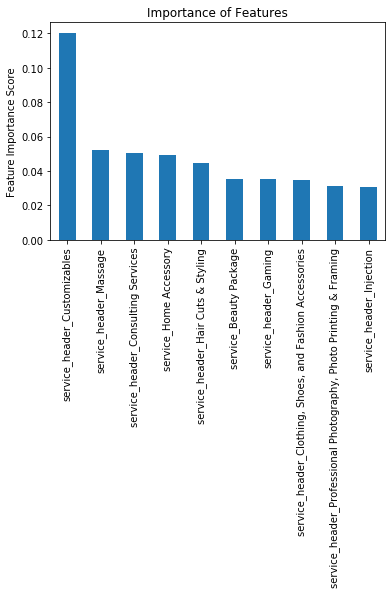

In [49]:
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp[:10].plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
accuracy = stats.spearmanr(baseline.predict(X_test), y_test)
print('Accuracy of the GBM on test set: {:.3f}'.format(accuracy[0]))

#### parameter tuning

##### 1. for loop function

In [50]:
n_estimators = [100, 200, 400]
learning_rate = [0.01, 0.05, 0.1, 0.2] 
min_samples_leaf = 10
max_depth = 2
estimators = []
rate = []
train_results = []
test_results = []
results = pd.DataFrame()

for n in n_estimators:
    for l in learning_rate:
        params = {
            'n_estimators': n,
            'learning_rate': l,
            'min_samples_leaf': 10,
            'max_depth': 2
        }
        gradient_boosting_regressor = GradientBoostingRegressor(**params)
        gradient_boosting_regressor.fit(X_train, y_train)
        y_test_pred = gradient_boosting_regressor.predict(X_test)
        y_train_pred = gradient_boosting_regressor.predict(X_train)
        estimators.append(n)
        rate.append(l)
        train_results.append(stats.spearmanr(y_test_pred, y_test)[0])
        test_results.append(stats.spearmanr(y_train_pred, y_train)[0])
# Append columns to the Empty DataFrame
results['n_estimators'] = estimators
results['learning_rate'] = rate
results['train_results'] = train_results
results['test_results'] = test_results    
results 

In [53]:
optimal_params = {
    'n_estimators': 400,
    'learning_rate': 0.20,
    'min_samples_leaf' : 10,
    'max_depth' : 2,
    'criterion': 'mse'
}

# n.trees = 200 interaction.depth = 2 shrinkage = 0.1
gradient_boosting_regressor = GradientBoostingRegressor(**optimal_params)

gradient_boosting_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.2, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

##### 2.builtin package GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://www.datacareer.ch/blog/parameter-tuning-in-gradient-boosting-gbm-with-python/(parameter tuning example)

* tune learning rate and n_estimators

In [520]:
p_test = {'learning_rate':[0.15,0.1,0.05,0.01], 
          'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

#Defining your scoring strategy from metric functions
from sklearn.metrics import fbeta_score, make_scorer
def my_custom_loss_func(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]
# score = make_scorer(my_custom_loss_func, greater_is_better = True)

tuning = GridSearchCV(estimator = GradientBoostingRegressor(max_depth=4, 
                                                            min_samples_split=2, 
                                                            min_samples_leaf=1, 
                                                            subsample=1,
                                                            random_state=10), 
                      param_grid = p_test, 
                      scoring = make_scorer(my_custom_loss_func, greater_is_better = True),
                      cv = 5)
tuning.fit(X_train,y_train)

In [514]:
tuning.cv_results_

{'mean_fit_time': array([5.89661603, 6.16797895]),
 'std_fit_time': array([0.15273902, 0.42383488]),
 'mean_score_time': array([0.09877696, 0.0871016 ]),
 'std_score_time': array([0.01656354, 0.00338848]),
 'param_learning_rate': masked_array(data=[0.15, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.15, 'n_estimators': 1},
  {'learning_rate': 0.1, 'n_estimators': 1}],
 'split0_test_score': array([0.2234734, 0.2234734]),
 'split1_test_score': array([0.21887179, 0.21887179]),
 'split2_test_score': array([0.21405013, 0.21405013]),
 'split3_test_score': array([0.21803762, 0.21803762]),
 'split4_test_score': array([0.21931475, 0.21931475]),
 'mean_test_score': array([0.21874954, 0.21874954]),
 'std_test_score': array([0.00300804, 0.00300804]),
 'rank_test_score': array([1, 1], dt

In [518]:
tuning.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [517]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'n_estimators': 1}, 0.2187495375843731)

* tune max_depth

In [ ]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.01,
                                                            n_estimators=1500), 
                      param_grid = p_test2, 
                      scoring = make_scorer(my_custom_loss_func, greater_is_better = True),
                      cv = 5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

* final model

In [521]:
model = GradientBoostingRegressor(learning_rate=0.1,
                                  n_estimators=200,
                                 max_depth = 2)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [522]:
y_pred = model.predict(X_test)
from scipy import stats
print('spearman correlation is {}'.format(stats.spearmanr(y_pred, y_test)[0]))

spearman correlation is 0.46365504769935817


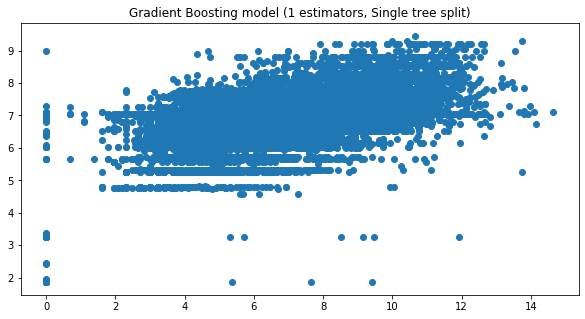

In [523]:
plt.figure(figsize=(10, 5))
plt.title('Gradient Boosting model (1 estimators, Single tree split)')
plt.scatter(y_test, y_pred)
# plt.plot(x, gradient_boosting_regressor.predict(x), color='r')
# plt.show()

### Second stage model

In [524]:
train['fs_score'] = model.predict(X_dummy)

In [531]:
remove_features = ["deal_uuid",
                   "deal_key",
                   "sf_id",
                    "deal_year",
                    "fine_print",
                    "title_rw",
                    "division",
                    "division_key",
                    "division_permalink",
                    "refund_rate",
                    "feature_refeature",
                    "udv_30",
                    "udv_90",
                    "pds_cat_id",
                    "pds_cat_name",
                    "service_header_id",
                    "service",
                    "service_header",
                    "runrank",
                    "first_run",
                    "service_45",
                    "hero_model",
                    "manually_adjusted_gb_value",
                    "competitor_name",
                    "gross_bookings",
                  "actual_start_date",
                  "actual_end_date"]

In [532]:
train.head()

,deal_uuid,deal_key,sf_id,deal_year,deal_month,actual_start_date,actual_end_date,voucher_age,days_ran,division_key,...,market_ly_60_avg_price,sh_365_avg_deal_gb,sh_365_avg_udv_30,sh_365_avg_udv_90,sh_365_deal_count,sh_365_merchant_count,sh_365_avg_discount,sh_365_avg_price,log_gb,fs_score
0,b8f33fe6-4776-4326-984a-071823c0d7dd,43563263,001C000001YfzvGIAR,2017,1,2017-01-15,2017-01-18,66.0,4,3500034,...,60.8375,5651.6,603.818182,1312.764706,18.0,14.0,84.150000,65.451389,4.248495,7.042088
1,b8fb9088-2dcf-42b1-aa05-ab09018a43e6,43609398,001C000001ZT9XnIAL,2017,2,2017-02-10,2017-02-13,66.0,4,3500116,...,60.8375,123.0,64.000000,95.000000,1.0,1.0,96.000000,60.666668,6.811795,6.804531
2,b8fcbb48-4093-4af2-8b2d-ef0a71700b8b,43624780,001C000001ZalFqIAJ,2017,2,2017-02-16,2017-02-19,66.0,4,3500179,...,60.8375,2888.0,1550.000000,2495.000000,1.0,1.0,22.333334,66.666664,10.695122,7.042088
3,b9043a56-193a-4cbf-bd6a-e608acdd36af,43632667,001C000001ZTkrZIAT,2017,2,2017-02-22,2017-02-21,66.0,0,3500021,...,60.8375,292.0,623.000000,624.000000,1.0,1.0,34.875000,36.375000,7.902303,7.042088
4,b90c37fa-4375-4f52-b406-5722717152c9,43614626,001C000001ZZwFjIAL,2017,2,2017-02-08,2017-02-11,66.0,4,3500161,...,60.8375,26195.0,1815.000000,3240.000000,1.0,1.0,183.500000,51.000000,6.075185,6.532064


In [533]:
train_new = train.drop(remove_features, axis = 1) 

In [534]:
train_new.head()

,deal_month,voucher_age,days_ran,peer_group,num_redemption_locations,category,min_unit_price,max_unit_price,average_unit_price,average_margin,...,market_ly_60_avg_price,sh_365_avg_deal_gb,sh_365_avg_udv_30,sh_365_avg_udv_90,sh_365_deal_count,sh_365_merchant_count,sh_365_avg_discount,sh_365_avg_price,log_gb,fs_score
0,1,66.0,4,Group 2,0,Services,32.0,93.0,58.000000,25.678572,...,60.8375,5651.6,603.818182,1312.764706,18.0,14.0,84.150000,65.451389,4.248495,7.042088
1,2,66.0,4,Group 3,0,Leisure Offers / Activities,29.0,49.0,41.000000,18.933332,...,60.8375,123.0,64.000000,95.000000,1.0,1.0,96.000000,60.666668,6.811795,6.804531
2,2,66.0,4,Group 2,0,Services,15.0,65.0,40.000000,17.200000,...,60.8375,2888.0,1550.000000,2495.000000,1.0,1.0,22.333334,66.666664,10.695122,7.042088
3,2,66.0,0,Group 5,0,Beauty / Wellness / Healthcare,34.0,97.5,65.333336,22.860000,...,60.8375,292.0,623.000000,624.000000,1.0,1.0,34.875000,36.375000,7.902303,7.042088
4,2,66.0,4,Group 4,3,Shopping,28.0,46.0,37.000000,7.950000,...,60.8375,26195.0,1815.000000,3240.000000,1.0,1.0,183.500000,51.000000,6.075185,6.532064


In [535]:
#One hot encoding 
train_new = pd.get_dummies(train_new)

In [536]:
train_new.head()

,deal_month,voucher_age,days_ran,num_redemption_locations,min_unit_price,max_unit_price,average_unit_price,average_margin,min_retail_price,max_retail_price,...,region_name_Great Lakes,region_name_Mid Atlantic,region_name_Midwest,region_name_Northeast,region_name_Northwest,region_name_South,region_name_Southeast,region_name_Southwest,divison_type_mulitple division,divison_type_single divison
0,1,66.0,4,0,32.0,93.0,58.000000,25.678572,95.00,140.00,...,0,0,0,0,0,1,0,0,0,1
1,2,66.0,4,0,29.0,49.0,41.000000,18.933332,60.00,120.00,...,0,1,0,0,0,0,0,0,1,0
2,2,66.0,4,0,15.0,65.0,40.000000,17.200000,29.99,129.99,...,0,0,0,0,0,0,0,0,1,0
3,2,66.0,0,0,34.0,97.5,65.333336,22.860000,54.00,162.00,...,0,0,0,1,0,0,0,0,1,0
4,2,66.0,4,3,28.0,46.0,37.000000,7.950000,149.00,249.00,...,0,0,0,0,0,0,1,0,1,0


In [544]:
X = train_new.iloc[:, :-1]
y = train_new['log_gb']

In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [546]:
X_train.head()

,deal_month,voucher_age,days_ran,num_redemption_locations,min_unit_price,max_unit_price,average_unit_price,average_margin,min_retail_price,max_retail_price,...,region_name_California,region_name_Great Lakes,region_name_Mid Atlantic,region_name_Midwest,region_name_Northeast,region_name_Northwest,region_name_South,region_name_Southeast,region_name_Southwest,divison_type_mulitple division
29845,5,66.0,0,0,6.0,6.0,6.0,3.00,10.0,10.0,...,0,0,0,0,1,0,0,0,0,1
41601,6,66.0,0,0,27.0,27.0,27.0,13.50,50.0,50.0,...,0,0,0,0,0,0,1,0,0,1
86476,1,66.0,0,0,62.0,62.0,62.0,31.00,75.0,75.0,...,0,0,1,0,0,0,0,0,0,0
108579,4,66.0,4,0,119.0,119.0,119.0,33.32,180.0,180.0,...,0,1,0,0,0,0,0,0,0,0
107462,4,66.0,0,0,12.0,12.0,12.0,6.00,17.0,17.0,...,0,0,0,0,1,0,0,0,0,1


In [547]:
y_train.head()

29845      6.095825
41601      3.295837
86476      4.820282
108579    10.322888
107462     3.178054
Name: log_gb, dtype: float64

In [554]:
import xgboost as xgb
# from xgb import xgbRegressor

In [558]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'max_depth' : 2,
    'criterion': 'mse'
}

xgbmodel = xgb.XGBRegressor(**params)
xgbmodel.fit(X_train, y_train)

[16:01:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, criterion='mse', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [560]:
import math

In [561]:
math.pow(1, 2)

1.0

In [564]:
stats.spearmanr(y_test, xgbmodel.predict(X_test))

SpearmanrResult(correlation=0.9999825921478592, pvalue=0.0)